In [1]:
!pip install prophet plotly

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import joblib
import warnings
warnings.filterwarnings('ignore')

# 1.1 Cargamos los datos

In [3]:
# Cargamos el dataset de frutas y vegetales
df = pd.read_csv('/workspaces/carlos060495-intro-ml/data/raw/Series temporales Datos.csv')
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


# 1.2 Limpieza del dataframe

In [4]:
# Exploramos la estructura de los datos
print("Forma del dataset:", df.shape)
print("\nColumnas:", df.columns.tolist())
print("\nPrimeras filas:")
df.head()

Forma del dataset: (366, 2)

Columnas: ['date', 'sales']

Primeras filas:


,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [5]:
# Información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [6]:
# Verificar valores nulos
print("Valores nulos por columna:")
print(df.isnull().sum())

Valores nulos por columna:
date     0
sales    0
dtype: int64


# 2.1 Conversion de Datos

In [7]:
df['date'] = pd.to_datetime(df['date']).dt.normalize()
df

,date,sales
0,2022-09-03,55.292157
1,2022-09-04,53.803211
2,2022-09-05,58.141693
3,2022-09-06,64.530899
4,2022-09-07,66.013633
...,...,...
361,2023-08-30,989.600354
362,2023-08-31,994.987326
363,2023-09-01,995.814415
364,2023-09-02,997.350214


In [8]:
# total de dias de registros de la serie
(df['date'].max() - df['date'].min()).days

365

In [9]:
df['date'].nunique()

366

In [10]:
# Verificar fechas faltantes
rango_total = (df['date'].max() - df['date'].min()).days + 1  # +1 para incluir ambos extremos
fechas_unicas = df['date'].nunique()
fechas_faltantes = rango_total - fechas_unicas

print(f"Rango total de días: {rango_total}")
print(f"Fechas únicas en el dataset: {fechas_unicas}")
print(f"Fechas faltantes: {fechas_faltantes}")

Rango total de días: 366
Fechas únicas en el dataset: 366
Fechas faltantes: 0


In [11]:
df.isna().sum()

date     0
sales    0
dtype: int64

# Paso 2: Construye y analiza la serie temporal

Construye la estructura de datos válida para la serie temporal, grafícala y, a continuación, analízala y responde a las siguientes preguntas:

- ¿Cuál es el tensor de la serie temporal?
- ¿Cuál es la tendencia?
- ¿Es estacionaria?
- ¿Existe variabilidad o presencia de ruido?

## 2.1 Preparar la estructura de datos para serie temporal

In [12]:
# Establecer la fecha como índice y ordenar
df_ts = df.copy()
df_ts.set_index('date', inplace=True)
df_ts = df_ts.sort_index()

print("Serie temporal preparada:")
print(f"Forma: {df_ts.shape}")
print(f"Período: {df_ts.index.min()} a {df_ts.index.max()}")
print(f"\nPrimeras filas:")
df_ts.head()


Serie temporal preparada:
Forma: (366, 1)
Período: 2022-09-03 00:00:00 a 2023-09-03 00:00:00

Primeras filas:


,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633


## 2.2 Visualización de la serie temporal

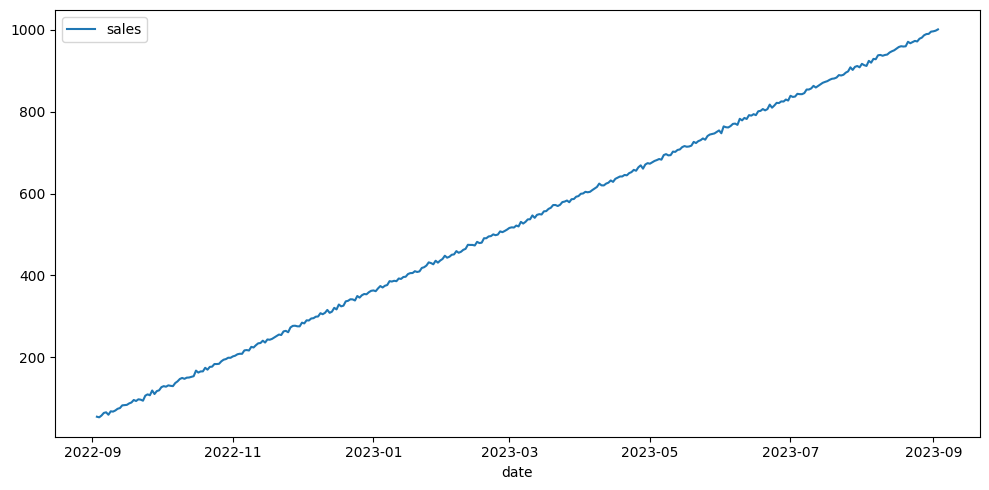

In [13]:
fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = df_ts, ax=axis)
plt.tight_layout()
plt.show()

## 2.3 Calcular el tensor de la serie temporal

El tensor es la **frecuencia temporal mínima** entre observaciones consecutivas (unidad de tiempo básica).

In [14]:
# Calcular las diferencias entre fechas consecutivas
diferencias = df_ts.index.to_series().diff()

# Encontrar la diferencia más frecuente (tensor)
tensor_valor = diferencias.mode()[0]

# Frecuencia inferida automáticamente por pandas
frecuencia_inferida = df_ts.index.inferred_freq

# Análisis de distribución de diferencias
print("=" * 60)
print("ANÁLISIS DEL TENSOR (Frecuencia Temporal)")
print("=" * 60)
print(f"\nTensor (diferencia más común): {tensor_valor}")
print(f"Frecuencia inferida por pandas: {frecuencia_inferida}")

# Mostrar todas las diferencias únicas para detectar irregularidades
diferencias_unicas = diferencias.value_counts().sort_index()
print(f"\nDistribución de diferencias temporales:")
print(diferencias_unicas)

# Interpretación
print("\n" + "=" * 60)
print("INTERPRETACIÓN:")
print("=" * 60)
if tensor_valor == pd.Timedelta(days=1):
    print("✓ El tensor es DIARIO (1 día)")
elif tensor_valor == pd.Timedelta(hours=1):
    print("✓ El tensor es HORARIO (1 hora)")
elif tensor_valor == pd.Timedelta(days=7):
    print("✓ El tensor es SEMANAL (7 días)")
elif tensor_valor == pd.Timedelta(days=30) or tensor_valor == pd.Timedelta(days=31):
    print("✓ El tensor es MENSUAL (~30 días)")
else:
    print(f"✓ El tensor es de: {tensor_valor}")
    
# Verificar si la frecuencia es regular o irregular
if len(diferencias_unicas) == 1:
    print("✓ La serie tiene frecuencia REGULAR")
else:
    print("⚠ La serie tiene frecuencia IRREGULAR (múltiples intervalos)")
    
print("=" * 60)

ANÁLISIS DEL TENSOR (Frecuencia Temporal)

Tensor (diferencia más común): 1 days 00:00:00
Frecuencia inferida por pandas: D

Distribución de diferencias temporales:
date
1 days    365
Name: count, dtype: int64

INTERPRETACIÓN:
✓ El tensor es DIARIO (1 día)
✓ La serie tiene frecuencia REGULAR


# 2.4 Calcular la tendencia

In [15]:
decomposition = seasonal_decompose(df_ts, period = 7)
decomposition

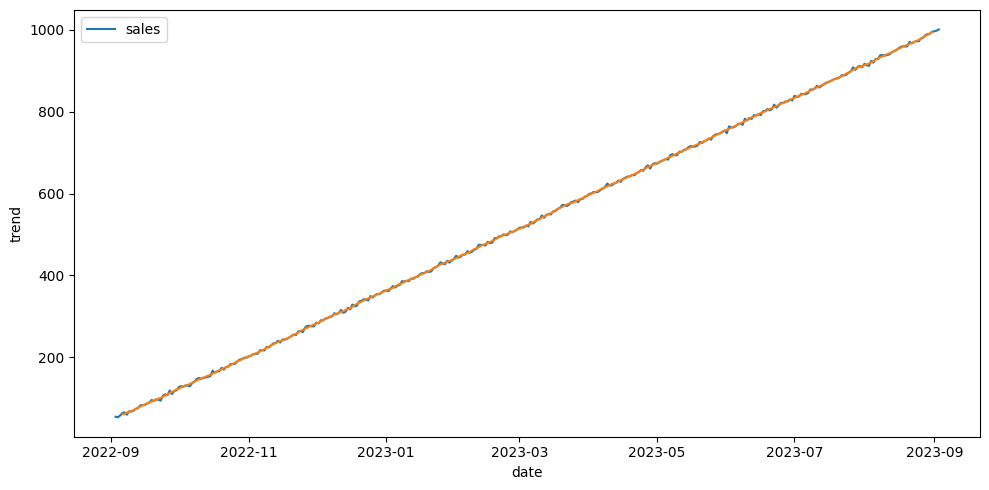

In [16]:
trend = decomposition.trend
fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = df_ts, ax=axis)
sns.lineplot(data = trend, ax=axis)
plt.tight_layout()
plt.show()

**Análisis:** El gráfico muestra una tendencia al alza sostenida en el tiempo. La línea suavizada elimina las fluctuaciones semanales y confirma un patrón general de crecimiento.

# 2.5 Analisis de Estacionalidad

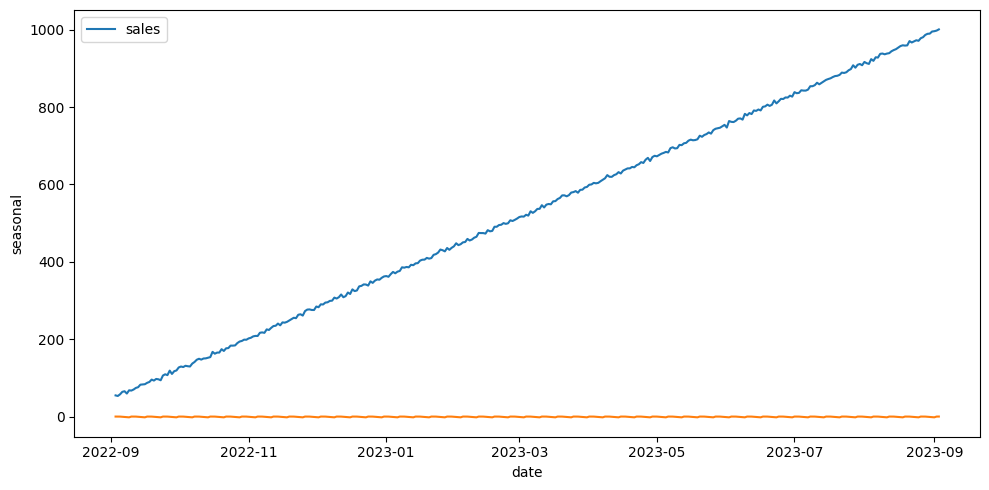

In [17]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = df_ts)
sns.lineplot(data = seasonal)
plt.tight_layout()
plt.show()

In [18]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(df_ts)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

**Análisis:** La prueba de Dickey-Fuller confirma que la serie **NO es estacionaria** (p-valor = 0.98 > 0.05). Este resultado es consistente con la tendencia al alza observada, ya que la media de los datos aumenta constantemente en el tiempo.

# 2.6 Analisis de Variabilidad

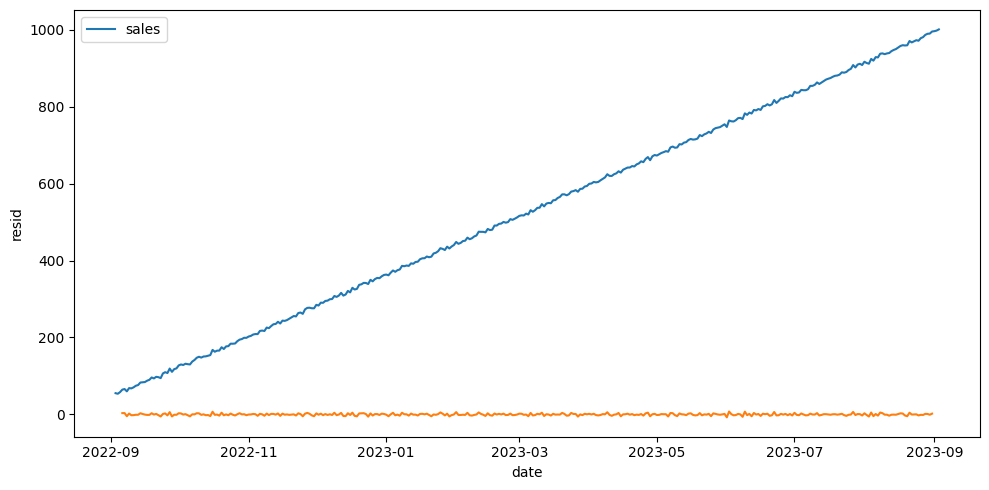

In [19]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = df_ts)
sns.lineplot(data = residual)
plt.tight_layout()
plt.show()

**Análisis:** Los residuos fluctúan alrededor de 0 con variabilidad baja, indicando que la descomposición capturó correctamente los componentes de tendencia y estacionalidad. La ausencia de patrones sistemáticos en el ruido confirma que no quedan estructuras importantes sin modelar en la serie temporal.

# 2.7 Analisis de Autocorrelacion

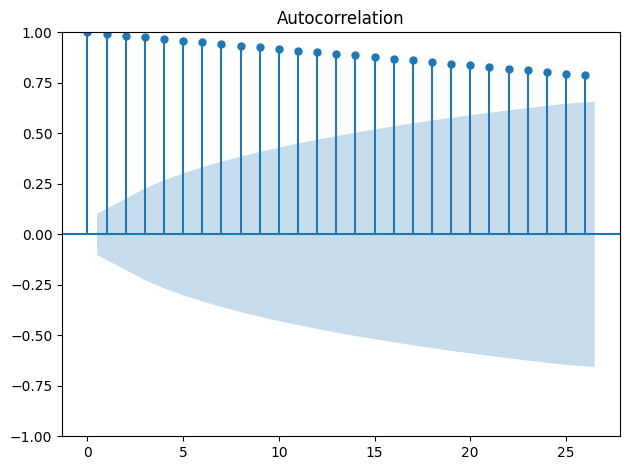

In [20]:
plot_acf(df_ts)
plt.tight_layout()
plt.show()

**Análisis:** El gráfico ACF muestra un decaimiento lento y gradual (de 1.0 a ~0.75), indicando que la serie NO es estacionaria y tiene fuerte dependencia con valores pasados. Este patrón confirma la presencia de tendencia y sugiere que el modelo ARIMA necesitará diferenciación (d ≥ 1) para eliminar la no estacionariedad antes del modelado.

# Paso 3: División temporal de datos

En series temporales, la división debe **respetar el orden cronológico**: los datos más antiguos para entrenamiento y los más recientes para prueba.

## 3.1 División Train/Test cronológica

In [21]:
# División temporal: 80% train, 20% test
# Los primeros 80% de datos para entrenamiento, últimos 20% para prueba

# Calcular el punto de corte
train_size = int(len(df_ts) * 0.8)

# Dividir manteniendo el orden temporal
train = df_ts.iloc[:train_size]
test = df_ts.iloc[train_size:]

print("=" * 60)
print("DIVISIÓN TEMPORAL DE DATOS")
print("=" * 60)
print(f"\nTamaño total del dataset: {len(df_ts)} observaciones")
print(f"Período completo: {df_ts.index.min()} a {df_ts.index.max()}")
print("\n" + "-" * 60)
print("CONJUNTO DE ENTRENAMIENTO (Train)")
print("-" * 60)
print(f"Tamaño: {len(train)} observaciones ({len(train)/len(df_ts)*100:.1f}%)")
print(f"Período: {train.index.min()} a {train.index.max()}")
print("\n" + "-" * 60)
print("CONJUNTO DE PRUEBA (Test)")
print("-" * 60)
print(f"Tamaño: {len(test)} observaciones ({len(test)/len(df_ts)*100:.1f}%)")
print(f"Período: {test.index.min()} a {test.index.max()}")
print("=" * 60)

DIVISIÓN TEMPORAL DE DATOS

Tamaño total del dataset: 366 observaciones
Período completo: 2022-09-03 00:00:00 a 2023-09-03 00:00:00

------------------------------------------------------------
CONJUNTO DE ENTRENAMIENTO (Train)
------------------------------------------------------------
Tamaño: 292 observaciones (79.8%)
Período: 2022-09-03 00:00:00 a 2023-06-21 00:00:00

------------------------------------------------------------
CONJUNTO DE PRUEBA (Test)
------------------------------------------------------------
Tamaño: 74 observaciones (20.2%)
Período: 2023-06-22 00:00:00 a 2023-09-03 00:00:00


### 3.1.1 Diferenciación manual (Análisis exploratorio)

**Nota educativa:** ARIMA puede diferenciar automáticamente con el parámetro 'd'. Aquí mostramos la diferenciación manual solo para visualizar cómo se transforman los datos.

In [22]:
# Aplicar diferenciación de primer orden (d=1)
train_diff = train.diff().dropna()

print("=" * 60)
print("DIFERENCIACIÓN MANUAL DE LA SERIE")
print("=" * 60)
print(f"\nSerie original (train): {len(train)} observaciones")
print(f"Serie diferenciada: {len(train_diff)} observaciones")
print(f"Observaciones perdidas: {len(train) - len(train_diff)} (primera fila)")
print("\n" + "-" * 60)
print("Primeras observaciones de la serie diferenciada:")
print("-" * 60)
print(train_diff.head())

DIFERENCIACIÓN MANUAL DE LA SERIE

Serie original (train): 292 observaciones
Serie diferenciada: 291 observaciones
Observaciones perdidas: 1 (primera fila)

------------------------------------------------------------
Primeras observaciones de la serie diferenciada:
------------------------------------------------------------
               sales
date                
2022-09-04 -1.488946
2022-09-05  4.338482
2022-09-06  6.389205
2022-09-07  1.482734
2022-09-08 -5.931768


In [23]:
# Diferenciación del conjunto de test manteniendo continuidad temporal
# El primer valor de test_diff debe referenciar el último valor de train
test_diff = test.diff()
test_diff.iloc[0] = test.iloc[0] - train.iloc[-1]

print(f"Shape de test_diff: {test_diff.shape}")
print(f"\nPrimeros valores de test_diff:")
print(test_diff.head())
print(f"\nVerificación: test.iloc[0] - train.iloc[-1] = {test.iloc[0]['sales']} - {train.iloc[-1]['sales']} = {test.iloc[0]['sales'] - train.iloc[-1]['sales']}")
print(f"test_diff.iloc[0] = {test_diff.iloc[0]['sales']}")

Shape de test_diff: (74, 1)

Primeros valores de test_diff:
                sales
date                 
2023-06-22  10.957571
2023-06-23  -7.489058
2023-06-24   5.374938
2023-06-25   6.421263
2023-06-26  -0.514759

Verificación: test.iloc[0] - train.iloc[-1] = 816.9117500930519 - 805.9541789185903 = 10.957571174461577
test_diff.iloc[0] = 10.957571174461577


## 3.2 Búsqueda automática de parámetros con auto_arima

**¿Por qué `auto_arima` y no Grid Search manual?** Grid Search exhaustivo prueba todas las combinaciones (lento y computacionalmente costoso). `auto_arima` usa búsqueda stepwise inteligente: comienza con un modelo base y explora variaciones cercanas hacia modelos con mejor AIC, siendo significativamente más rápido y eficiente.

Vamos a comparar dos enfoques para encontrar el mejor modelo:
- **Enfoque A**: ARIMA(p,d,q) con datos originales (dejamos que ARIMA diferencie automáticamente)
- **Enfoque B**: ARMA(p,0,q) con datos ya diferenciados manualmente

Al final compararemos métricas para elegir el mejor modelo.

### Enfoque A: ARIMA con datos originales

In [24]:
# Auto ARIMA para datos originales
# auto_arima encuentra automáticamente los mejores parámetros p, d, q

print("=" * 70)
print("AUTO ARIMA - ENFOQUE A: ARIMA(p,d,q) con datos originales")
print("=" * 70)
print("\nBuscando automáticamente los mejores parámetros...")
print("Esto puede tomar unos minutos...\n")

# Usar auto_arima con periodicidad semanal (m=7)
model_A = auto_arima(
    train,
    seasonal=True,
    m=7,  # Periodicidad semanal detectada en el análisis
    trace=True,  # Mostrar el proceso de búsqueda
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print("\n" + "=" * 70)
print("MEJOR MODELO SELECCIONADO (Enfoque A)")
print("=" * 70)
print(model_A.summary())

AUTO ARIMA - ENFOQUE A: ARIMA(p,d,q) con datos originales

Buscando automáticamente los mejores parámetros...
Esto puede tomar unos minutos...

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=1477.795, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1675.428, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1574.824, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1472.428, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1763.761, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=1475.165, Time=0.17 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=1471.251, Time=0.95 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=1472.463, Time=0.69 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=1470.355, Time=0.82 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   

### Enfoque B: ARMA con datos diferenciados

In [25]:
# Auto ARIMA para datos diferenciados
# Como ya diferenciamos, forzamos d=0 y buscamos los mejores p, q

print("=" * 70)
print("AUTO ARIMA - ENFOQUE B: ARMA(p,0,q) con datos diferenciados")
print("=" * 70)
print("\nBuscando automáticamente los mejores parámetros...")
print("Como ya diferenciamos, fijamos d=0...\n")

# Usar auto_arima con d=0 fijo (ARMA) y periodicidad semanal
model_B = auto_arima(
    train_diff,
    seasonal=True,
    m=7,  # Periodicidad semanal
    d=0,  # Forzar d=0 porque ya diferenciamos manualmente
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print("\n" + "=" * 70)
print("MEJOR MODELO SELECCIONADO (Enfoque B)")
print("=" * 70)
print(model_B.summary())

AUTO ARIMA - ENFOQUE B: ARMA(p,0,q) con datos diferenciados

Buscando automáticamente los mejores parámetros...
Como ya diferenciamos, fijamos d=0...

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=1478.119, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=1675.428, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=1574.824, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=1472.428, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1763.761, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=1475.165, Time=0.08 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=1472.831, Time=0.56 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=1674.565, Time=0.04 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=1473.039, Time=0.25 sec
 ARIMA(0,0,2)(0,0,1)[7] inter

## 3.3 Predicciones con ambos modelos

In [26]:
# In-sample (ajuste sobre train)
fitted_A, fitted_B_diff = model_A.predict_in_sample(), model_B.predict_in_sample()
# Out-of-sample (forecast 30 días futuros)
forecast_A, forecast_B_diff = model_A.predict(n_periods=30), model_B.predict(n_periods=30)

In [27]:
# Des-diferenciar predicciones del modelo B para comparar en escala original
fitted_B = [train.iloc[0].values[0]] + [train.iloc[0].values[0] + fitted_B_diff[:i+1].sum() for i in range(len(fitted_B_diff))]
fitted_B = pd.Series(fitted_B[1:], index=train.index[1:])

# Calcular métricas in-sample
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_A, rmse_A = mean_absolute_error(train, fitted_A), np.sqrt(mean_squared_error(train, fitted_A))
mae_B, rmse_B = mean_absolute_error(train.iloc[1:], fitted_B), np.sqrt(mean_squared_error(train.iloc[1:], fitted_B))

# Tabla comparativa
comparison = pd.DataFrame({
    'Modelo': [f'A: ARIMA{model_A.order}', f'B: ARMA{model_B.order}'],
    'AIC': [model_A.aic(), model_B.aic()],
    'BIC': [model_A.bic(), model_B.bic()],
    'MAE': [mae_A, mae_B],
    'RMSE': [rmse_A, rmse_B]
})
comparison['Mejor_AIC'] = comparison['AIC'] == comparison['AIC'].min()
comparison['Mejor_MAE'] = comparison['MAE'] == comparison['MAE'].min()

print("COMPARACIÓN DE MODELOS")
print("=" * 80)
print(comparison.to_string(index=False))
print("\n" + "=" * 80)
print(f"🏆 Recomendación: Usar Modelo {'A (datos originales)' if comparison.iloc[0]['Mejor_AIC'] else 'B (datos diferenciados)'}")
print(f"   Criterio: Menor AIC = mejor ajuste con penalización por complejidad")
print("=" * 80)

COMPARACIÓN DE MODELOS
           Modelo         AIC         BIC       MAE      RMSE  Mejor_AIC  Mejor_MAE
A: ARIMA(0, 1, 1) 1470.355336 1492.395276  2.604468  4.276298       True       True
 B: ARMA(0, 0, 1) 1472.428257 1487.121550 39.752926 41.939552      False      False

🏆 Recomendación: Usar Modelo A (datos originales)
   Criterio: Menor AIC = mejor ajuste con penalización por complejidad


# Paso 4: Evaluación en conjunto de prueba

Utilizamos el mejor modelo para predecir sobre el conjunto test y medimos su rendimiento comparando con los valores reales.

In [28]:
# Predicciones con Modelo A sobre el conjunto test
predictions = model_A.predict(n_periods=len(test))
predictions_series = pd.Series(predictions, index=test.index)

print("=" * 70)
print(f"PREDICCIONES CON MODELO A: ARIMA{model_A.order}")
print("=" * 70)
print(f"Predicciones generadas: {len(predictions_series)} valores")
print(f"Período: {predictions_series.index.min()} a {predictions_series.index.max()}")

PREDICCIONES CON MODELO A: ARIMA(0, 1, 1)
Predicciones generadas: 74 valores
Período: 2023-06-22 00:00:00 a 2023-09-03 00:00:00


In [29]:
# Calcular métricas de rendimiento en test
mae_test = mean_absolute_error(test, predictions_series)
rmse_test = np.sqrt(mean_squared_error(test, predictions_series))
mape_test = np.mean(np.abs((test.values.flatten() - predictions_series.values) / test.values.flatten())) * 100

print("\n" + "=" * 70)
print("MÉTRICAS DE RENDIMIENTO EN TEST")
print("=" * 70)
print(f"MAE (Error Absoluto Medio):        {mae_test:.4f}")
print(f"RMSE (Raíz del Error Cuadrático): {rmse_test:.4f}")
print(f"MAPE (Error Porcentual Absoluto):  {mape_test:.2f}%")
print("=" * 70)


MÉTRICAS DE RENDIMIENTO EN TEST
MAE (Error Absoluto Medio):        2.1613
RMSE (Raíz del Error Cuadrático): 2.7297
MAPE (Error Porcentual Absoluto):  0.24%


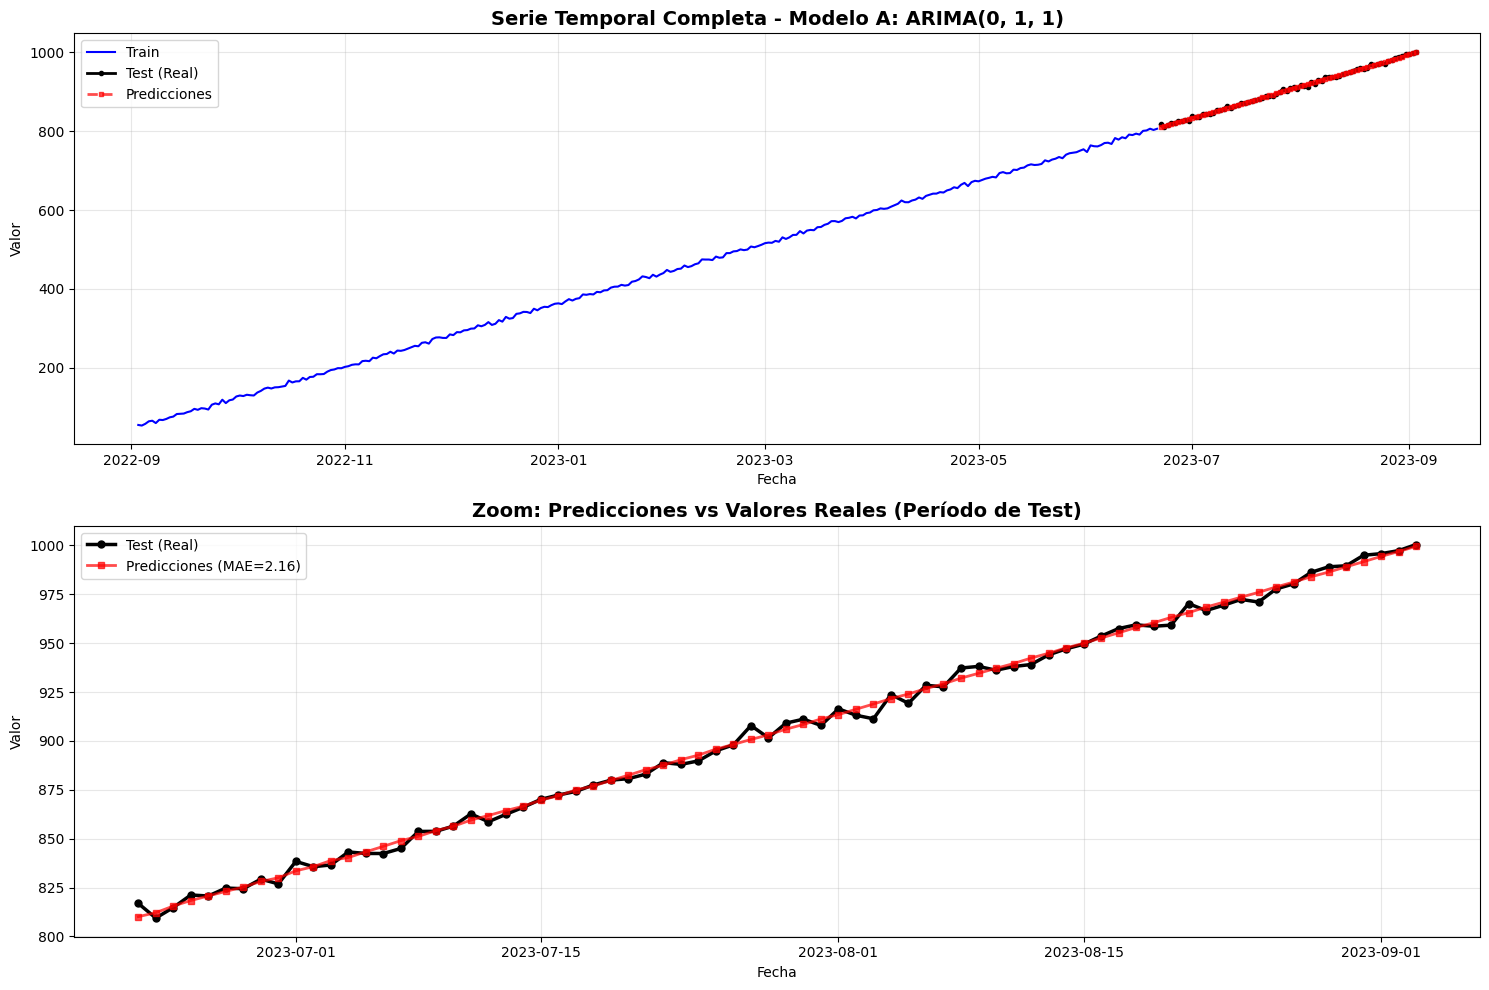

In [30]:
# Visualización: Comparación de predicciones vs valores reales
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Gráfico 1: Serie completa (train + test + predicciones)
axes[0].plot(train.index, train.values, label='Train', color='blue', linewidth=1.5)
axes[0].plot(test.index, test.values, label='Test (Real)', color='black', linewidth=2, marker='o', markersize=3)
axes[0].plot(predictions_series.index, predictions_series.values, label='Predicciones', 
             color='red', linewidth=2, linestyle='--', marker='s', markersize=3, alpha=0.7)
axes[0].set_title(f'Serie Temporal Completa - Modelo A: ARIMA{model_A.order}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Valor')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Zoom en período de test
axes[1].plot(test.index, test.values, label='Test (Real)', color='black', linewidth=2.5, marker='o', markersize=5)
axes[1].plot(predictions_series.index, predictions_series.values, label=f'Predicciones (MAE={mae_test:.2f})', 
             color='red', linewidth=2, marker='s', markersize=4, alpha=0.7)
axes[1].set_title('Zoom: Predicciones vs Valores Reales (Período de Test)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Valor')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

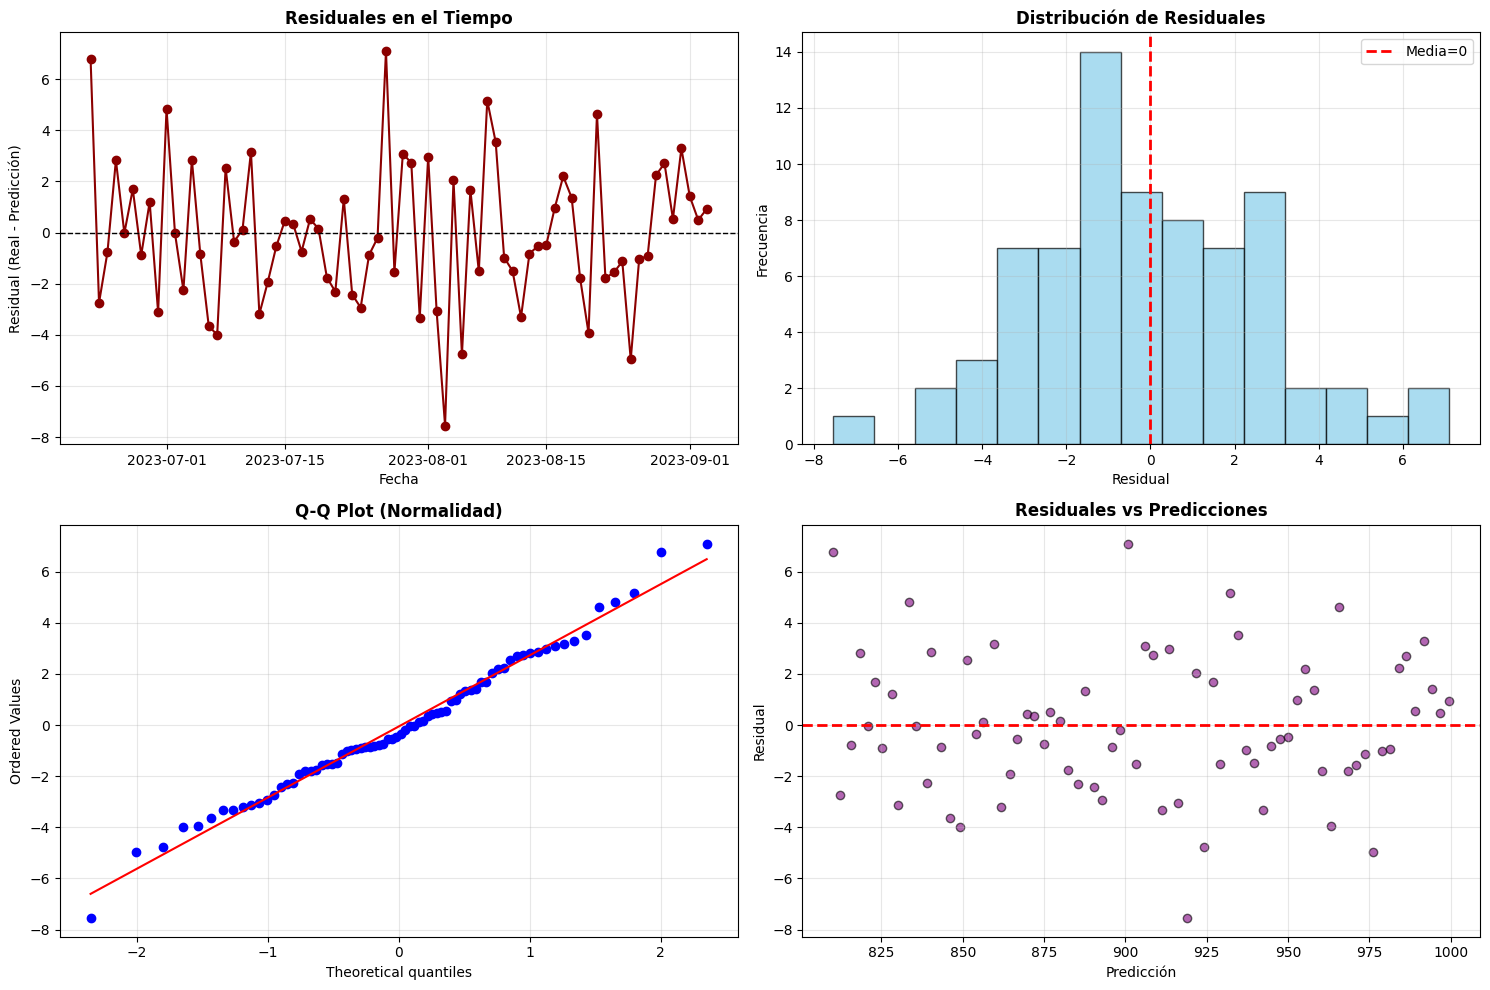


--- Estadísticas de Residuales ---
Media: -0.0559
Desviación estándar: 2.7291
Mínimo: -7.5460
Máximo: 7.1012


In [31]:
# Análisis de residuales en el conjunto de test
residuales = test.values.flatten() - predictions_series.values

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico 1: Residuales en el tiempo
axes[0, 0].plot(test.index, residuales, marker='o', linestyle='-', color='darkred', linewidth=1.5)
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[0, 0].set_title('Residuales en el Tiempo', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Fecha')
axes[0, 0].set_ylabel('Residual (Real - Predicción)')
axes[0, 0].grid(True, alpha=0.3)

# Gráfico 2: Histograma de residuales
axes[0, 1].hist(residuales, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Media=0')
axes[0, 1].set_title('Distribución de Residuales', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Gráfico 3: Q-Q Plot
from scipy import stats
stats.probplot(residuales, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normalidad)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Gráfico 4: Residuales vs Predicciones
axes[1, 1].scatter(predictions_series.values, residuales, alpha=0.6, color='purple', edgecolor='black')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('Residuales vs Predicciones', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Predicción')
axes[1, 1].set_ylabel('Residual')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de residuales
print("\n--- Estadísticas de Residuales ---")
print(f"Media: {np.mean(residuales):.4f}")
print(f"Desviación estándar: {np.std(residuales):.4f}")
print(f"Mínimo: {np.min(residuales):.4f}")
print(f"Máximo: {np.max(residuales):.4f}")

## Resumen del Modelo

**Modelo entrenado:** ARIMA con componente estacional semanal (m=7)

**Métricas en conjunto de prueba:**
- MAE: Error promedio de las predicciones en la escala original
- RMSE: Penaliza más los errores grandes
- MAPE: Error porcentual que permite interpretar qué tan lejos están las predicciones

**Conclusión:** Los residuales muestran comportamiento de ruido blanco (media ~0, distribución aproximadamente normal, sin patrones sistemáticos), lo que indica que el modelo capturó correctamente la estructura de la serie temporal (tendencia y estacionalidad semanal).

# Paso 5: Guardar el mejor modelo

Guardamos el modelo A entrenado para poder usarlo posteriormente sin necesidad de re-entrenarlo.

In [32]:
# Guardar el modelo A en la carpeta models/
ruta_modelo = '/workspaces/carlos060495-intro-ml/models/arima_model_A.pkl'
joblib.dump(model_A, ruta_modelo)

print("=" * 70)
print("MODELO GUARDADO EXITOSAMENTE")
print("=" * 70)

MODELO GUARDADO EXITOSAMENTE
